In [1]:
import os
import pandas as pd
from PIL import Image
import numpy as np
import cv2
import seaborn as sns
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split
from pathlib import Path
from tqdm import tqdm

2025-04-17 19:18:01.197933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744917481.498331      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744917481.588941      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load First Dataset (Kaggle)

In [2]:
base_path = '/kaggle/input/chest-xray-covid19-pneumonia/Data'

categories = ['NORMAL']
images = []
labels = []

In [3]:
def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png') :  # Only process .jpg files
            img_path = os.path.join(folder, filename)
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

In [4]:
train_path = os.path.join(base_path, 'train')
for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category)
    
test_path = os.path.join(base_path, 'test')
test_images = []
test_labels = []
for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category)

Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL...


In [5]:
images = np.array(images)
labels = np.array(labels)

In [6]:
images = images[:480]
labels = labels[:480]

# Load Second Dataset (Github)

In [7]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3641, done.
remote: Total 3641 (delta 0), reused 0 (delta 0), pack-reused 3641 (from 1)
Receiving objects: 100% (3641/3641), 632.96 MiB | 45.84 MiB/s, done.
Resolving deltas: 100% (1450/1450), done.
Updating files: 100% (1174/1174), done.


In [8]:
data_dir = "/kaggle/working/covid-chestxray-dataset/images/"
metadata_path = "/kaggle/working/covid-chestxray-dataset/metadata.csv"

In [9]:
metadata = pd.read_csv("/kaggle/working/covid-chestxray-dataset/metadata.csv")

In [10]:
xray_metadata = metadata[metadata['modality'].str.lower() == 'x-ray']
xray_filenames = xray_metadata['filename'].tolist()

image_link = [file for file in os.listdir(data_dir)]
xray_images = []
xray_labels = []

for i, filename in enumerate(tqdm(xray_filenames, desc="Loading and labeling X-ray images")):
    if filename in image_link:
        finding = xray_metadata.iloc[i]['finding']

        if "covid-19" in finding.lower():
            new_label = "COVID-19"
        elif finding == "No Finding":
            new_label = "Normal"
        elif "pneumonia" in finding.lower() and "covid-19" not in finding.lower():
            new_label = "Pneumonia"
        else:
            continue

        img_path = os.path.join(data_dir, filename)
        try:
            image = Image.open(img_path).convert("RGB")
            image_array = np.array(image)
            img = cv2.resize(image_array, (224, 224))
            xray_images.append(img)
            xray_labels.append(new_label)
        except FileNotFoundError:
            print(f"Image not found: {img_path}")

print(f"Number of X-ray images loaded: {len(xray_images)}")
print(f"Label distribution:\n{pd.Series(xray_labels).value_counts()}")

Loading and labeling X-ray images: 100%|██████████| 866/866 [00:21<00:00, 39.71it/s]

Number of X-ray images loaded: 764
Label distribution:
COVID-19     504
Pneumonia    242
Normal        18
Name: count, dtype: int64


In [11]:
images_2 = np.array(xray_images)
labels_2 = np.array(xray_labels)

# Merge

In [12]:
All_images = np.concatenate((images, images_2), axis=0)
All_labels = np.concatenate((labels, labels_2), axis=0)

In [13]:
unified_labels = [label.replace('-', '').lower() for label in All_labels]
label_mapping = {original: unified for original, unified in zip(All_labels, unified_labels)}
All_labels = np.array([label_mapping[label] for label in All_labels])

In [14]:
set(All_labels)

{'covid19', 'normal', 'pneumonia'}

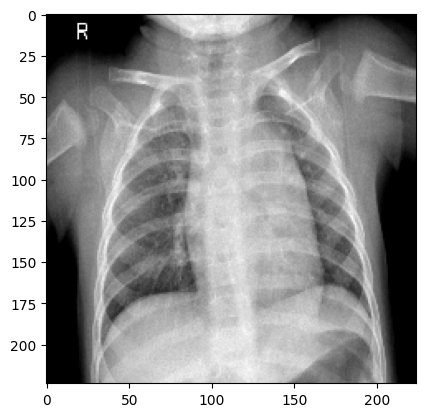

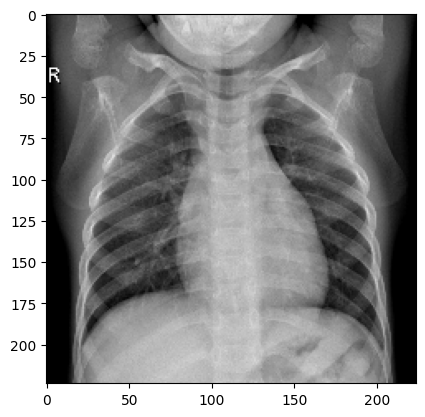

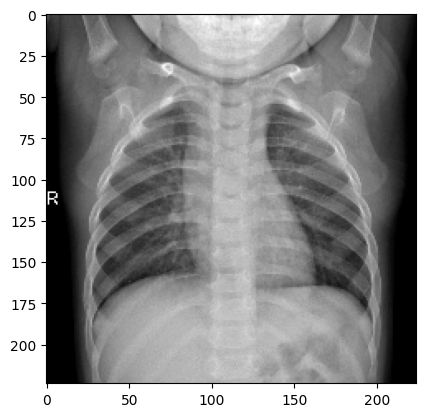

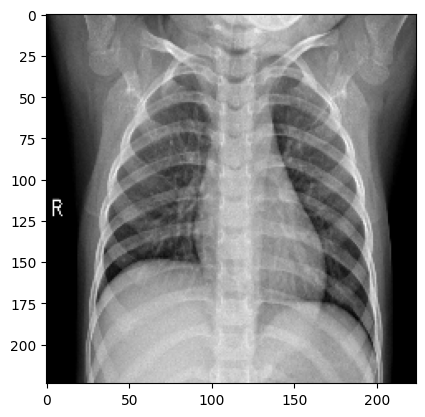

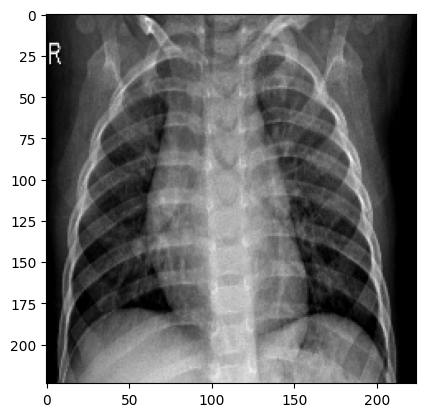

In [15]:
for i in range(5):
  plt.imshow(All_images[i])
  plt.show()

# Save for next stage

In [16]:
base_dir = "/kaggle/working/dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
class_names = ['covid19', 'normal', 'pneumonia']
zip_file = "dataset.zip"

for split_dir in [train_dir, test_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(split_dir, class_name), exist_ok=True)

X_train, X_test, y_train, y_test = train_test_split(
    All_images, All_labels, test_size=0.2, stratify=All_labels, random_state=42
)

def save_images(images, labels, split_dir):
    for idx, (img, label) in enumerate(zip(images, labels)):
        class_name = label  # <-- fixed here
        img_path = os.path.join(split_dir, class_name, f"image_{idx}.png")
        img_scaled = (img - img.min()) / (img.max() - img.min())
        img_uint8 = (img_scaled * 255).astype(np.uint8)
        if len(img.shape) == 2:
            img_uint8 = img_uint8[..., np.newaxis]
        cv2.imwrite(img_path, img_uint8)


save_images(X_train, y_train, train_dir)
save_images(X_test, y_test, test_dir)

shutil.make_archive(base_dir, 'zip', base_dir)
shutil.rmtree(base_dir)

print(f"\nDataset saved as {zip_file}")


Dataset saved as dataset.zip
